In [1]:
import pandas as pd
import xarray as xr

import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import Polygon, mapping
import cartopy.feature as cfeat
import cartopy.crs as ccrs
import regionmask
import xesmf as xe
import cmocean

from matplotlib import ticker

import sys
sys.path.append('../')
import utils
import plotting

import math

In [7]:
import string
alphabet = list(string.ascii_lowercase)


# Import Data and Count mortalities

In [8]:
ds_o3_mort = xr.open_zarr('./final_data/o3_mortalities.zarr')
ds_PM_mort = xr.open_zarr('./final_data/pm_mortalities.zarr')

In [9]:
ds_PM= xr.open_dataset('./final_data/ds_PM_O3_daily.nc4')
ds_o3 = xr.open_dataset('./final_data/ds_O3_mda8.nc4')



In [10]:
#rename ozone and convert to ppb
ds_o3 = ds_o3.rename({'SpeciesConc_O3':'O3'})['O3']


In [11]:
#list of model names
model_names = ds_PM['model_name'].values


## Mask data to US

In [12]:
#### create a mask ####
states = regionmask.defined_regions.natural_earth.us_states_50
lon = np.arange(230, 300, .25)
lat = np.arange(50, 24, -.125)
mask = states.mask(ds_PM, lon_name = 'lon', lat_name = 'lat')
contiguous_mask = ~np.isnan(mask) & (mask != 0.) & (mask != 11) 

#### mask our population dataset ####
ds_o3_mort = ds_o3_mort.where(contiguous_mask)
ds_PM_mort = ds_PM_mort.where(contiguous_mask)
ds_PM = ds_PM.where(contiguous_mask)
ds_o3 = ds_o3.where(contiguous_mask)


# Plot

## No Nuclear

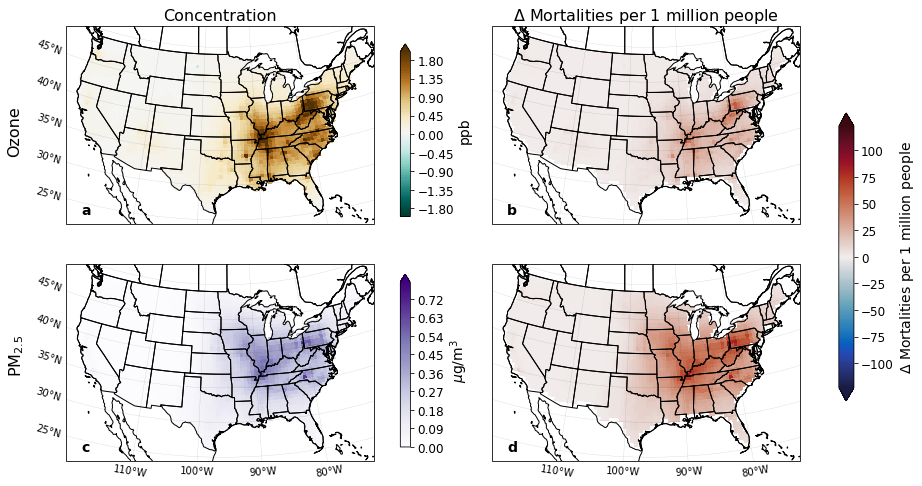

In [13]:
fig = plt.figure(figsize=[14,8])

### O3 No Nuclear plot ###
cmap = 'BrBG_r'
lev = np.squeeze(np.arange(-123,123.5,.5))
lev_pol =  np.squeeze(np.arange(-2.0,2.05,.05))
ax_o3 = fig.add_subplot(2,2,1, projection=ccrs.LambertConformal())
o3 = (ds_o3.sel(model_name = 'nonuc_NA')-ds_o3.sel(model_name = 'normal_NA')).mean(dim = 'time').plot(ax = ax_o3,  
                                                                                  add_colorbar=False, 
                                                                                  cmap = cmap,transform=ccrs.PlateCarree(),
                                                                                  levels = lev_pol, 
                                                                                  extend = 'max')
ax_o3.set_title('Concentration', fontsize = 16)
ax_o3.add_feature(cfeat.STATES)
ax_o3.coastlines()
ax_o3.set_extent(plotting.lat_lon)

gl = ax_o3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
gl.right_labels = gl.top_labels = gl.bottom_labels = False
gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])

## O3 colorbar ##
cbar_ax = fig.add_axes([.48, 0.55, 0.01, 0.3])
cb = fig.colorbar(o3, cax=cbar_ax)
cbar_ax.tick_params(labelsize=10) 
cb.set_label(label = r'ppb', fontsize=14)
cb.ax.tick_params(labelsize='large')


### O3 No Nuclear Mortalities ###
cmap = cmocean.cm.balance
ax_o3_mort = fig.add_subplot(2,2,2, projection=ccrs.LambertConformal())
pc = (1e6*ds_o3_mort['Δmortality_mean'].sel(model_name = 'nonuc_NA')/ds_o3_mort['regrid_pop_count']).plot(ax = ax_o3_mort,  
                                                                                  add_colorbar=False, 
                                                                                  cmap = cmap,transform=ccrs.PlateCarree(),
                                                                                  levels = lev, 
                                                                                  extend = 'both')
ax_o3_mort.set_title('$\Delta$ Mortalities per 1 million people', fontsize = 16)
ax_o3_mort.add_feature(cfeat.STATES)
ax_o3_mort.coastlines()
ax_o3_mort.set_extent(plotting.lat_lon)

gl = ax_o3_mort.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
gl.right_labels = gl.top_labels = gl.left_labels = gl.bottom_labels = False
gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])

### PM No Nuclear plot ###
cmap = 'Purples'
lev_pol =  np.squeeze(np.arange(0,.81,.01))
ax_pm = fig.add_subplot(2,2,3, projection=ccrs.LambertConformal())
pm = (ds_PM['PM25'].sel( model_name = 'nonuc_NA')-ds_PM['PM25'].sel(model_name = 'normal_NA')).mean(dim = 'time').plot(ax = ax_pm, 
                                                         add_colorbar=False, cmap = cmap,
                                                         transform=ccrs.PlateCarree(),
                                                         levels = lev_pol, 
                                                         extend = 'max')
ax_pm.set_title(r' ', fontsize = 16)
ax_pm.add_feature(cfeat.STATES)
ax_pm.coastlines()
ax_pm.set_extent(plotting.lat_lon)

gl = ax_pm.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
gl.right_labels = gl.top_labels = False
gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])


## PM colorbar ##
cbar_ax = fig.add_axes([.48, 0.15, 0.01, 0.3])
cb = fig.colorbar(pm, cax=cbar_ax)
cbar_ax.tick_params(labelsize=10) 
cb.set_label(label = r'$\mu$g/m$^3$', fontsize=14)
cb.ax.tick_params(labelsize='large')


### PM No Nuclear Mortalities###
cmap = cmocean.cm.balance
ax_pm_mort = fig.add_subplot(2,2,4, projection=ccrs.LambertConformal())
(1e6*ds_PM_mort['Δmortality_mean'].sel(model_name = 'nonuc_NA')/ds_PM_mort['regrid_pop_count']).plot(ax = ax_pm_mort, 
                                                         add_colorbar=False, cmap = cmap,
                                                         transform=ccrs.PlateCarree(),
                                                         levels = lev, 
                                                         extend = 'both')
ax_pm_mort.set_title(r' ', fontsize = 16)
ax_pm_mort.add_feature(cfeat.STATES)
ax_pm_mort.coastlines()
ax_pm_mort.set_extent(plotting.lat_lon)

gl = ax_pm_mort.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
gl.right_labels = gl.top_labels = gl.left_labels = False
gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])



### Mortality color bar #####
cbar_ax = fig.add_axes([.915, 0.23, 0.015, 0.5])
cb = fig.colorbar(pc, cax=cbar_ax)
cbar_ax.tick_params(labelsize=10) 

cb.set_label(label = '$\Delta$ Mortalities per 1 million people', fontsize=14)
cb.ax.tick_params(labelsize='large')

for label, ax in zip(alphabet, [ax_o3, ax_o3_mort, ax_pm, ax_pm_mort]):
    ax.text(x = .05, y =.05, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)

### Titles ###

fig.text(.09,.66,'Ozone', fontsize = 16, rotation = 'vertical')
fig.text(.09,.28,'PM$_{2.5}$', fontsize = 16, rotation = 'vertical')

#plt.tight_layout()
plt.savefig('./Figures/main_paper/mortalities_poll_nonuc.png', bbox_inches = 'tight', dpi = 350)

## No Nuclear No Coal

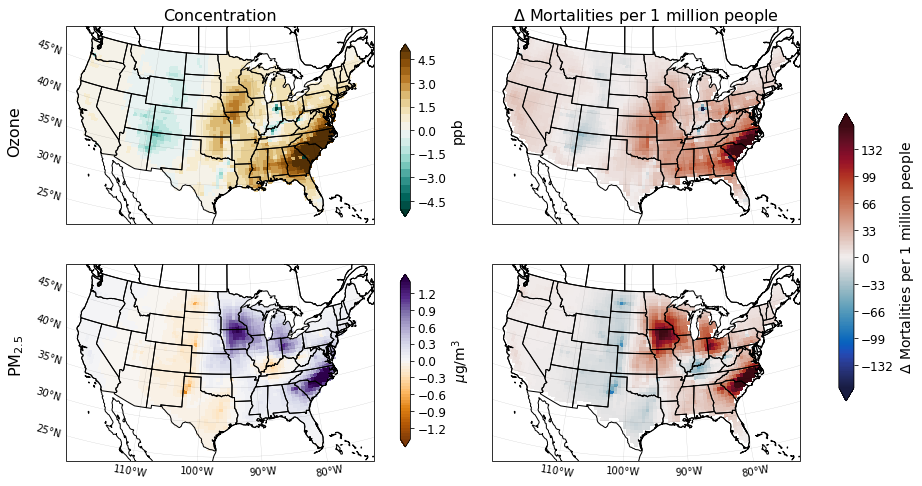

In [12]:
fig = plt.figure(figsize=[14,8])

### O3 No Nuclear plot ###
cmap = 'BrBG_r'
lev = np.squeeze(np.arange(-160,161,1))
lev_pol =  np.squeeze(np.arange(-5.0,5.05,.5))
ax_o3 = fig.add_subplot(2,2,1, projection=ccrs.LambertConformal())
o3 = (ds_o3.sel(model_name = 'nonuc_coal_NA')-ds_o3.sel(model_name = 'normal_NA')).mean(dim = 'time').plot(ax = ax_o3,  
                                                                                  add_colorbar=False, 
                                                                                  cmap = cmap,transform=ccrs.PlateCarree(),
                                                                                  levels = lev_pol, 
                                                                                  extend = 'both')
ax_o3.set_title('Concentration', fontsize = 16)
ax_o3.add_feature(cfeat.STATES)
ax_o3.coastlines()
ax_o3.set_extent(plotting.lat_lon)

gl = ax_o3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
gl.right_labels = gl.top_labels = gl.bottom_labels = False
gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])

## O3 colorbar ##
cbar_ax = fig.add_axes([.48, 0.55, 0.01, 0.3])
cb = fig.colorbar(o3, cax=cbar_ax)
cbar_ax.tick_params(labelsize=10) 
cb.set_label(label = r'ppb', fontsize=14)
cb.ax.tick_params(labelsize='large')


### O3 No Nuclear Mortalities ###
cmap = cmocean.cm.balance
ax_o3_mort = fig.add_subplot(2,2,2, projection=ccrs.LambertConformal())
pc = (1e6*ds_o3_mort['Δmortality_mean'].sel(model_name = 'nonuc_coal_NA')/ds_o3_mort['regrid_pop_count']).plot(ax = ax_o3_mort,  
                                                                                  add_colorbar=False, 
                                                                                  cmap = cmap,transform=ccrs.PlateCarree(),
                                                                                  levels = lev, 
                                                                                  extend = 'both')
ax_o3_mort.set_title('$\Delta$ Mortalities per 1 million people', fontsize = 16)
ax_o3_mort.add_feature(cfeat.STATES)
ax_o3_mort.coastlines()
ax_o3_mort.set_extent(plotting.lat_lon)

gl = ax_o3_mort.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
gl.right_labels = gl.top_labels = gl.left_labels = gl.bottom_labels = False
gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])

### PM No Nuclear plot ###
cmap = 'PuOr'
lev_pol =  np.squeeze(np.arange(-1.4,1.45,.05))
ax_pm = fig.add_subplot(2,2,3, projection=ccrs.LambertConformal())
pm = (ds_PM['PM25'].sel( model_name = 'nonuc_coal_NA')-ds_PM['PM25'].sel(model_name = 'normal_NA')).mean(dim = 'time').plot(ax = ax_pm, 
                                                         add_colorbar=False, cmap = cmap,
                                                         transform=ccrs.PlateCarree(),
                                                         levels = lev_pol, 
                                                         extend = 'both')
ax_pm.set_title(r' ', fontsize = 16)
ax_pm.add_feature(cfeat.STATES)
ax_pm.coastlines()
ax_pm.set_extent(plotting.lat_lon)

gl = ax_pm.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
gl.right_labels = gl.top_labels = False
gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])

## PM colorbar ##
cbar_ax = fig.add_axes([.48, 0.15, 0.01, 0.3])
cb = fig.colorbar(pm, cax=cbar_ax)
cbar_ax.tick_params(labelsize=10) 
cb.set_label(label = r'$\mu$g/m$^3$', fontsize=14)
cb.ax.tick_params(labelsize='large')


### PM No Nuclear Mortalities###
cmap = cmocean.cm.balance
ax_pm_mort = fig.add_subplot(2,2,4, projection=ccrs.LambertConformal())
(1e6*ds_PM_mort['Δmortality_mean'].sel(model_name = 'nonuc_coal_NA')/ds_PM_mort['regrid_pop_count']).plot(ax = ax_pm_mort, 
                                                         add_colorbar=False, cmap = cmap,
                                                         transform=ccrs.PlateCarree(),
                                                         levels = lev, 
                                                         extend = 'both')
ax_pm_mort.set_title(r' ', fontsize = 16)
ax_pm_mort.add_feature(cfeat.STATES)
ax_pm_mort.coastlines()
ax_pm_mort.set_extent(plotting.lat_lon)


gl = ax_pm_mort.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
gl.right_labels = gl.top_labels = gl.left_labels = False
gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])



### Mortality color bar #####
cbar_ax = fig.add_axes([.915, 0.23, 0.015, 0.5])
cb = fig.colorbar(pc, cax=cbar_ax)
cbar_ax.tick_params(labelsize=10) 

cb.set_label(label = '$\Delta$ Mortalities per 1 million people', fontsize=14)
cb.ax.tick_params(labelsize='large')


### Titles ###

fig.text(.09,.66,'Ozone', fontsize = 16, rotation = 'vertical')
fig.text(.09,.28,'PM$_{2.5}$', fontsize = 16, rotation = 'vertical')

#plt.tight_layout()
plt.savefig('./Figures/mortalities_poll_nonuc_coal.png', bbox_inches = 'tight', dpi = 350)

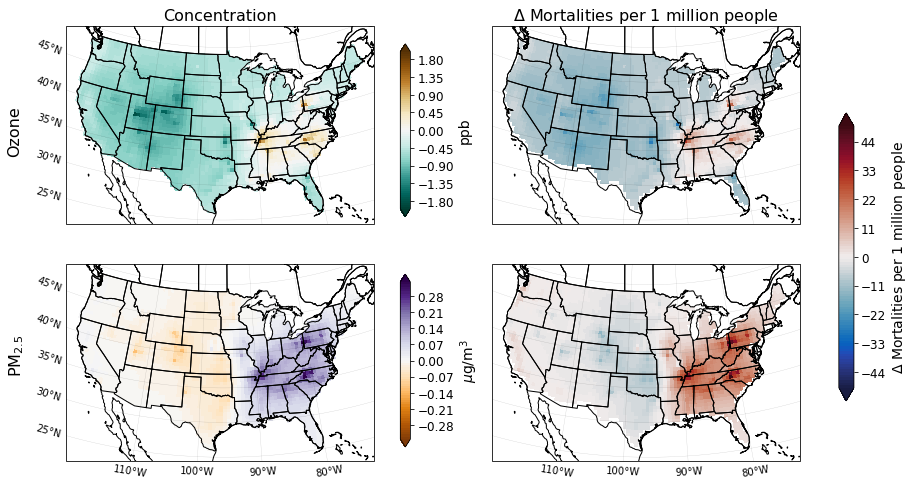

In [13]:
fig = plt.figure(figsize=[14,8])

### O3 No Nuclear plot ###
cmap = 'BrBG_r'
lev = np.squeeze(np.arange(-50,51,1))
lev_pol =  np.round(np.squeeze(np.arange(-2.0,2.05,.05)),2)
ax_o3 = fig.add_subplot(2,2,1, projection=ccrs.LambertConformal())
o3 = (ds_o3.sel(model_name = 'renew_nonuc_NA')-ds_o3.sel(model_name = 'normal_NA')).mean(dim = 'time').plot(ax = ax_o3,  
                                                                                  add_colorbar=False, 
                                                                                  cmap = cmap,transform=ccrs.PlateCarree(),
                                                                                  levels = lev_pol, 
                                                                                  extend = 'both')
ax_o3.set_title('Concentration', fontsize = 16)
ax_o3.add_feature(cfeat.STATES)
ax_o3.coastlines()
ax_o3.set_extent(plotting.lat_lon)

gl = ax_o3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
gl.right_labels = gl.top_labels = gl.bottom_labels = False
gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])

## O3 colorbar ##
cbar_ax = fig.add_axes([.48, 0.55, 0.01, 0.3])
cb = fig.colorbar(o3, cax=cbar_ax)
cbar_ax.tick_params(labelsize=10) 
cb.set_label(label = r'ppb', fontsize=14)
cb.ax.tick_params(labelsize='large')


### O3 No Nuclear Mortalities ###
cmap = cmocean.cm.balance
ax_o3_mort = fig.add_subplot(2,2,2, projection=ccrs.LambertConformal())
pc = (1e6*ds_o3_mort['Δmortality_mean'].sel(model_name = 'renew_nonuc_NA')/ds_o3_mort['regrid_pop_count']).plot(ax = ax_o3_mort,  
                                                                                  add_colorbar=False, 
                                                                                  cmap = cmap,transform=ccrs.PlateCarree(),
                                                                                  levels = lev, 
                                                                                  extend = 'both')
ax_o3_mort.set_title('$\Delta$ Mortalities per 1 million people', fontsize = 16)
ax_o3_mort.add_feature(cfeat.STATES)
ax_o3_mort.coastlines()
ax_o3_mort.set_extent(plotting.lat_lon)

gl = ax_o3_mort.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
gl.right_labels = gl.top_labels = gl.left_labels = gl.bottom_labels = False
gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])

### PM No Nuclear plot ###
cmap = 'PuOr'
lev_pol =  np.squeeze(np.arange(-.34,.35,.01))
ax_pm = fig.add_subplot(2,2,3, projection=ccrs.LambertConformal())
pm = (ds_PM['PM25'].sel( model_name = 'renew_nonuc_NA')-ds_PM['PM25'].sel(model_name = 'normal_NA')).mean(dim = 'time').plot(ax = ax_pm, 
                                                         add_colorbar=False, cmap = cmap,
                                                         transform=ccrs.PlateCarree(),
                                                         levels = lev_pol, 
                                                         extend = 'both')
ax_pm.set_title(r' ', fontsize = 16)
ax_pm.add_feature(cfeat.STATES)
ax_pm.coastlines()
ax_pm.set_extent(plotting.lat_lon)

gl = ax_pm.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
gl.right_labels = gl.top_labels = False
gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])

## PM colorbar ##
cbar_ax = fig.add_axes([.48, 0.15, 0.01, 0.3])
cb = fig.colorbar(pm, cax=cbar_ax)
cbar_ax.tick_params(labelsize=10) 
cb.set_label(label = r'$\mu$g/m$^3$', fontsize=14)
cb.ax.tick_params(labelsize='large')


### PM No Nuclear Mortalities###
cmap = cmocean.cm.balance
ax_pm_mort = fig.add_subplot(2,2,4, projection=ccrs.LambertConformal())
(1e6*ds_PM_mort['Δmortality_mean'].sel(model_name = 'renew_nonuc_NA')/ds_PM_mort['regrid_pop_count']).plot(ax = ax_pm_mort, 
                                                         add_colorbar=False, cmap = cmap,
                                                         transform=ccrs.PlateCarree(),
                                                         levels = lev, 
                                                         extend = 'both')
ax_pm_mort.set_title(r' ', fontsize = 16)
ax_pm_mort.add_feature(cfeat.STATES)
ax_pm_mort.coastlines()
ax_pm_mort.set_extent(plotting.lat_lon)


gl = ax_pm_mort.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
gl.right_labels = gl.top_labels = gl.left_labels = False
gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])



### Mortality color bar #####
cbar_ax = fig.add_axes([.915, 0.23, 0.015, 0.5])
cb = fig.colorbar(pc, cax=cbar_ax)
cbar_ax.tick_params(labelsize=10) 

cb.set_label(label = '$\Delta$ Mortalities per 1 million people', fontsize=14)
cb.ax.tick_params(labelsize='large')


### Titles ###

fig.text(.09,.66,'Ozone', fontsize = 16, rotation = 'vertical')
fig.text(.09,.28,'PM$_{2.5}$', fontsize = 16, rotation = 'vertical')

#plt.tight_layout()
plt.savefig('./Figures/mortalities_poll_nonuc_renew.png', bbox_inches = 'tight', dpi = 350)

## No Nuclear + No Coal and No Nuclear + Renewables

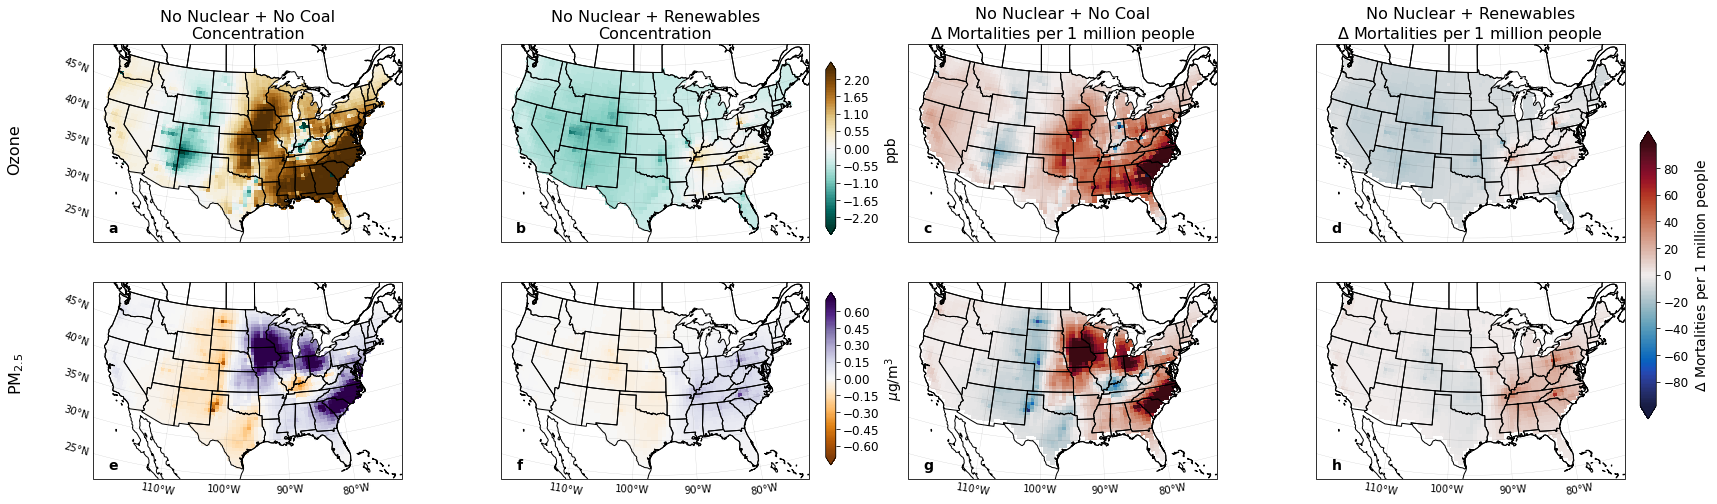

In [14]:
fig = plt.figure(figsize=[28,8])

### O3 No Nuclear plot ###
cmap = 'BrBG_r'
lev = np.squeeze(np.arange(-98,99,1))
lev_pol =  np.round(np.squeeze(np.arange(-2.5,2.55,.05)),2)
ax_o3 = fig.add_subplot(2,4,1, projection=ccrs.LambertConformal())
o3 = (ds_o3.sel(model_name = 'nonuc_coal_NA')-ds_o3.sel(model_name = 'normal_NA')).mean(dim = 'time').plot(ax = ax_o3,  
                                                                                  add_colorbar=False, 
                                                                                  cmap = cmap,transform=ccrs.PlateCarree(),
                                                                                  levels = lev_pol, 
                                                                                  extend = 'both')
ax_o3.set_title('No Nuclear + No Coal\nConcentration', fontsize = 16)
ax_o3.add_feature(cfeat.STATES)
ax_o3.coastlines()
ax_o3.set_extent(plotting.lat_lon)

gl = ax_o3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
gl.right_labels = gl.top_labels = gl.bottom_labels = False
gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])

### O3 Renewables plot ###
ax_o3_ren = fig.add_subplot(2,4,2, projection=ccrs.LambertConformal())
o3 = (ds_o3.sel(model_name = 'renew_nonuc_NA')-ds_o3.sel(model_name = 'normal_NA')).mean(dim = 'time').plot(ax = ax_o3_ren,  
                                                                                  add_colorbar=False, 
                                                                                  cmap = cmap,transform=ccrs.PlateCarree(),
                                                                                  levels = lev_pol, 
                                                                                  extend = 'both')
ax_o3_ren.set_title('No Nuclear + Renewables\nConcentration', fontsize = 16)
ax_o3_ren.add_feature(cfeat.STATES)
ax_o3_ren.coastlines()
ax_o3_ren.set_extent(plotting.lat_lon)

gl = ax_o3_ren.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
gl.right_labels = gl.top_labels = gl.left_labels = gl.bottom_labels = False
gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])

## O3 colorbar ##cbar_ax = fig.add_axes([.5, 0.15, 0.005, 0.3])

cbar_ax = fig.add_axes([.496, 0.55, 0.005, 0.3])
cb = fig.colorbar(o3, cax=cbar_ax)
cbar_ax.tick_params(labelsize=10) 
cb.set_label(label = r'ppb', fontsize=14)
cb.ax.tick_params(labelsize='large')


### O3 No Nuclear Mortalities ###
cmap = cmocean.cm.balance
ax_o3_mort = fig.add_subplot(2,4,3, projection=ccrs.LambertConformal())
pc = (1e6*ds_o3_mort['Δmortality_mean'].sel(model_name = 'nonuc_coal_NA')/ds_o3_mort['regrid_pop_count']).plot(ax = ax_o3_mort,  
                                                                                  add_colorbar=False, 
                                                                                  cmap = cmap,transform=ccrs.PlateCarree(),
                                                                                  levels = lev, 
                                                                                  extend = 'both')
ax_o3_mort.set_title('No Nuclear + No Coal\n$\Delta$ Mortalities per 1 million people', fontsize = 16)
ax_o3_mort.add_feature(cfeat.STATES)
ax_o3_mort.coastlines()
ax_o3_mort.set_extent(plotting.lat_lon)

gl = ax_o3_mort.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
gl.right_labels = gl.top_labels = gl.left_labels = gl.bottom_labels = False
gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])



### O3 Renew Mortalities ###
cmap = cmocean.cm.balance
ax_o3_mort_ren = fig.add_subplot(2,4,4, projection=ccrs.LambertConformal())
pc = (1e6*ds_o3_mort['Δmortality_mean'].sel(model_name = 'renew_nonuc_NA')/ds_o3_mort['regrid_pop_count']).plot(ax = ax_o3_mort_ren,  
                                                                                  add_colorbar=False, 
                                                                                  cmap = cmap,transform=ccrs.PlateCarree(),
                                                                                  levels = lev, 
                                                                                  extend = 'both')
ax_o3_mort_ren.set_title('No Nuclear + Renewables\n$\Delta$ Mortalities per 1 million people', fontsize = 16)
ax_o3_mort_ren.add_feature(cfeat.STATES)
ax_o3_mort_ren.coastlines()
ax_o3_mort_ren.set_extent(plotting.lat_lon)

gl = ax_o3_mort_ren.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
gl.right_labels = gl.top_labels = gl.left_labels = gl.bottom_labels = False
gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])




########################## PM PLOTS ##########################

### PM No Nuclear plot ###
cmap = 'PuOr'
lev_pol =  np.squeeze(np.arange(-.7,.71,.01))
ax_pm = fig.add_subplot(2,4,5, projection=ccrs.LambertConformal())
pm = (ds_PM['PM25'].sel( model_name = 'nonuc_coal_NA')-ds_PM['PM25'].sel(model_name = 'normal_NA')).mean(dim = 'time').plot(ax = ax_pm, 
                                                         add_colorbar=False, cmap = cmap,
                                                         transform=ccrs.PlateCarree(),
                                                         levels = lev_pol, 
                                                         extend = 'both')
ax_pm.set_title(r' ', fontsize = 16)
ax_pm.add_feature(cfeat.STATES)
ax_pm.coastlines()
ax_pm.set_extent(plotting.lat_lon)

gl = ax_pm.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
gl.right_labels = gl.top_labels = False
gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])


### PM renew plot ###
ax_pm_ren = fig.add_subplot(2,4,6, projection=ccrs.LambertConformal())
pm = (ds_PM['PM25'].sel( model_name = 'renew_nonuc_NA')-ds_PM['PM25'].sel(model_name = 'normal_NA')).mean(dim = 'time').plot(ax = ax_pm_ren, 
                                                         add_colorbar=False, cmap = cmap,
                                                         transform=ccrs.PlateCarree(),
                                                         levels = lev_pol, 
                                                         extend = 'both')
ax_pm_ren.set_title(r' ', fontsize = 16)
ax_pm_ren.add_feature(cfeat.STATES)
ax_pm_ren.coastlines()
ax_pm_ren.set_extent(plotting.lat_lon)

gl = ax_pm_ren.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
gl.right_labels = gl.top_labels = gl.left_labels = False
gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])


## PM colorbar ##
cbar_ax = fig.add_axes([.496, 0.15, 0.005, 0.3])
cb = fig.colorbar(pm, cax=cbar_ax)
cbar_ax.tick_params(labelsize=10) 
cb.set_label(label = r'$\mu$g/m$^3$', fontsize=14)
cb.ax.tick_params(labelsize='large')


### PM No Nuclear Mortalities###
cmap = cmocean.cm.balance
ax_pm_mort = fig.add_subplot(2,4,7, projection=ccrs.LambertConformal())
(1e6*ds_PM_mort['Δmortality_mean'].sel(model_name = 'nonuc_coal_NA')/ds_PM_mort['regrid_pop_count']).plot(ax = ax_pm_mort, 
                                                         add_colorbar=False, cmap = cmap,
                                                         transform=ccrs.PlateCarree(),
                                                         levels = lev, 
                                                         extend = 'both')
ax_pm_mort.set_title(r' ', fontsize = 16)
ax_pm_mort.add_feature(cfeat.STATES)
ax_pm_mort.coastlines()
ax_pm_mort.set_extent(plotting.lat_lon)

gl = ax_pm_mort.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
gl.right_labels = gl.top_labels = gl.left_labels = False
gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])


### PM Renewables Mortalities###
cmap = cmocean.cm.balance
ax_pm_mort_ren = fig.add_subplot(2,4,8, projection=ccrs.LambertConformal())
(1e6*ds_PM_mort['Δmortality_mean'].sel(model_name = 'renew_nonuc_NA')/ds_PM_mort['regrid_pop_count']).plot(ax = ax_pm_mort_ren, 
                                                         add_colorbar=False, cmap = cmap,
                                                         transform=ccrs.PlateCarree(),
                                                         levels = lev, 
                                                         extend = 'both')
ax_pm_mort_ren.set_title(r' ', fontsize = 16)
ax_pm_mort_ren.add_feature(cfeat.STATES)
ax_pm_mort_ren.coastlines()
ax_pm_mort_ren.set_extent(plotting.lat_lon)

gl = ax_pm_mort_ren.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
gl.right_labels = gl.top_labels = gl.left_labels = False
gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])



### Mortality color bar #####
cbar_ax = fig.add_axes([.9, 0.23, 0.008, 0.5])
cb = fig.colorbar(pc, cax=cbar_ax)
cbar_ax.tick_params(labelsize=10) 

cb.set_label(label = '$\Delta$ Mortalities per 1 million people', fontsize=14)
cb.ax.tick_params(labelsize='large')

for label, ax in zip(alphabet, [ax_o3, ax_o3_ren, ax_o3_mort, ax_o3_mort_ren, ax_pm, ax_pm_ren, ax_pm_mort, ax_pm_mort_ren]):
    ax.text(x = .05, y =.05, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)

### Titles ###

fig.text(.09,.66,'Ozone', fontsize = 16, rotation = 'vertical')
fig.text(.09,.28,'PM$_{2.5}$', fontsize = 16, rotation = 'vertical')

#plt.tight_layout()
plt.savefig('./Figures/supplement/mortalities_poll_both_renew_nonuc.png', bbox_inches = 'tight', dpi = 350)